In [2]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.loader import NeighborLoader
from torch_geometric.nn import SAGEConv, GATConv
from torch_geometric.utils import to_undirected
# load co-occurrence graph
import torch
from torch_geometric.transforms import RandomLinkSplit


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the preprocessed graph data
graph_data_path = "../data/msk_2024_graph_data_gene_one_hot.pt"
graph = torch.load(graph_data_path, map_location=device, weights_only=False)


splitter = RandomLinkSplit(is_undirected=True, num_test = 0.15, num_val = 0.15)
train_data, val_data, test_data = splitter(graph)

print("Train Data:")
print(train_data)
print("Validation Data:")
print(val_data)
print("Test Data:")
print(test_data)

Train Data:
Data(edge_index=[2, 14596], edge_attr=[14596, 1], num_nodes=262, x=[262, 262], edge_label=[14596], edge_label_index=[2, 14596])
Validation Data:
Data(edge_index=[2, 14596], edge_attr=[14596, 1], num_nodes=262, x=[262, 262], edge_label=[3126], edge_label_index=[2, 3126])
Test Data:
Data(edge_index=[2, 17722], edge_attr=[17722, 1], num_nodes=262, x=[262, 262], edge_label=[3126], edge_label_index=[2, 3126])


In [3]:
import torch

class GeneMutationGNN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=4):
        """
        GNN for Gene Mutation Embeddings using GraphSAGE + GAT.

        Args:
            in_channels (int): Feature size (number of genes)
            hidden_channels (int): Hidden layer size
            out_channels (int): Embedding size
            heads (int): Number of attention heads for GAT
        """
        super(GeneMutationGNN, self).__init__()

        # First layer: GraphSAGE for adaptive feature aggregation
        self.sage1 = SAGEConv(in_channels, hidden_channels)

        # Second layer: Graph Attention Network (multi-head)
        self.gat = GATConv(hidden_channels, hidden_channels, heads=heads, concat=False)

        # Final layer: Another GraphSAGE for refinement
        self.sage2 = SAGEConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.sage1(x, edge_index)
        x = F.relu(x)
        x = self.gat(x, edge_index)
        x = F.relu(x)
        x = self.sage2(x, edge_index)
        return x


In [4]:
def graph_reconstruction_loss(embeddings, edge_index, edge_weight):
    """
    Computes reconstruction loss based on edge weights.

    Args:
        embeddings (torch.Tensor): Node embeddings (N, d)
        edge_index (SparseTensor): Edge list
        edge_weight (torch.Tensor): Edge weights (E,)

    Returns:
        torch.Tensor: MSE loss for edge reconstruction
    """
    u, v = edge_index.coo()  # Convert sparse tensor to COO format

    # Compute similarity between connected node embeddings
    pred_sim = F.cosine_similarity(embeddings[u], embeddings[v])

    # Normalize edge weights (optional)
    edge_weight = (edge_weight - edge_weight.min()) / (edge_weight.max() - edge_weight.min() + 1e-8)

    # Mean Squared Error (MSE) Loss
    loss = F.mse_loss(pred_sim, edge_weight)

    return loss


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.nn import GCNConv, GATConv, BatchNorm

def train_gnn(model, train_graph, val_graph, epochs=100, learning_rate=0.01):
    """
    Train the GNN on the co-occurrence graph.

    Parameters:
    - model: GNN model.
    - train_graph: Training PyTorch Geometric graph object.
    - val_graph: Validation PyTorch Geometric graph object.
    - epochs: Number of training epochs.
    - learning_rate: Learning rate for the optimizer.

    Returns:
    - model: Trained GNN model.
    - train_losses, val_losses: Lists of training and validation losses.
    """
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    loss_fn = nn.MSELoss()

    # Move model and graph to the same device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    train_graph = train_graph.to(device)
    val_graph = val_graph.to(device)
    
    # Ensure edge attributes are float32 to prevent dtype mismatch
    train_graph.edge_attr = train_graph.edge_attr.float()
    val_graph.edge_attr = val_graph.edge_attr.float()

    train_losses, val_losses = [], []

    print(f"Graph Properties: {train_graph.num_nodes} nodes, {train_graph.num_edges} edges")
    
    for epoch in range(1, epochs + 1):
        model.train()
        optimizer.zero_grad()

        # Forward pass
        out = model(train_graph.x, train_graph.edge_index)

        # Compute edge attribute predictions
        edge_attr_pred = (out[train_graph.edge_index[0]] * out[train_graph.edge_index[1]]).sum(dim=1, keepdim=True)

        # Ensure predicted shape matches target shape
        train_loss = loss_fn(edge_attr_pred, train_graph.edge_attr)

        # Backpropagation
        train_loss.backward()
        optimizer.step()
        train_losses.append(train_loss.item())

        # Validation
        model.eval()
        with torch.no_grad():
            val_out = model(val_graph.x, val_graph.edge_index)
            val_edge_attr_pred = (
                val_out[val_graph.edge_index[0]] * val_out[val_graph.edge_index[1]]
            ).sum(dim=1, keepdim=True)

            val_loss = loss_fn(val_edge_attr_pred, val_graph.edge_attr)
            val_losses.append(val_loss.item())

        # Log progress
        if epoch % 5 == 0 or epoch == epochs:
            print(
                f"Epoch {epoch}/{epochs}, Train Loss: {train_loss.item():.4f}, "
                f"Val Loss: {val_loss.item():.4f}"
            )

    print("Training Complete!")
    return model, train_losses, val_losses


Graph Properties: 262 nodes, 14596 edges
Epoch 5/1000, Train Loss: 2.1577, Val Loss: 0.1887
Epoch 10/1000, Train Loss: 2.1759, Val Loss: 1.1139
Epoch 15/1000, Train Loss: 0.2164, Val Loss: 0.8035
Epoch 20/1000, Train Loss: 0.5396, Val Loss: 0.7024
Epoch 25/1000, Train Loss: 0.4755, Val Loss: 0.2604
Epoch 30/1000, Train Loss: 0.1872, Val Loss: 0.2348
Epoch 35/1000, Train Loss: 0.2098, Val Loss: 0.2837
Epoch 40/1000, Train Loss: 0.2476, Val Loss: 0.2067
Epoch 45/1000, Train Loss: 0.1839, Val Loss: 0.1843
Epoch 50/1000, Train Loss: 0.1860, Val Loss: 0.1995
Epoch 55/1000, Train Loss: 0.1871, Val Loss: 0.1740
Epoch 60/1000, Train Loss: 0.1746, Val Loss: 0.1700
Epoch 65/1000, Train Loss: 0.1690, Val Loss: 0.1682
Epoch 70/1000, Train Loss: 0.1656, Val Loss: 0.1662
Epoch 75/1000, Train Loss: 0.1641, Val Loss: 0.1640
Epoch 80/1000, Train Loss: 0.1622, Val Loss: 0.1615
Epoch 85/1000, Train Loss: 0.1602, Val Loss: 0.1597
Epoch 90/1000, Train Loss: 0.1591, Val Loss: 0.1587
Epoch 95/1000, Train Los

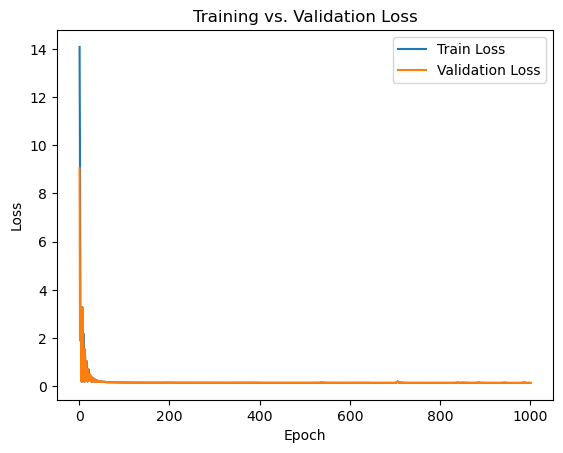

Test Loss: 0.1536


In [19]:
import matplotlib.pyplot as plt

# Model parameters
in_channels = graph.x.shape[1]  # Number of genes (one-hot features)
hidden_channels = 128
out_channels = 64  # Size of learned embeddings
num_epochs = 100
learning_rate = 0.005

# Initialize model
model = GeneMutationGNN(in_channels, hidden_channels, out_channels)

model = model.to(device)
# Train the GNN
model, train_losses, val_losses = train_gnn(model, train_data, val_data, epochs=1000, learning_rate=0.01)

# Plot loss curves
plt.plot(range(1, len(train_losses) + 1), train_losses, label="Train Loss")
plt.plot(range(1, len(val_losses) + 1), val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs. Validation Loss")
plt.show()

def evaluate_gnn(model, test_graph):
    model.eval()
    with torch.no_grad():
        out = model(test_graph.x, test_graph.edge_index)
        # Compute edge attribute predictions for the test set
        edge_attr_pred = (out[test_graph.edge_index[0]] * out[test_graph.edge_index[1]]).sum(dim=1, keepdim=True)
        test_loss = F.mse_loss(edge_attr_pred, test_graph.edge_attr)
        print(f"Test Loss: {test_loss.item():.4f}")
# Evaluate the GNN on the test set
evaluate_gnn(model, test_data)


In [20]:
# Put the model in evaluation mode
model.eval()

# Perform a forward pass to get the gene mutation embeddings
with torch.no_grad():
    gene_embeddings = model(graph.x, graph.edge_index)

gene_embeddings.shape

torch.Size([262, 64])

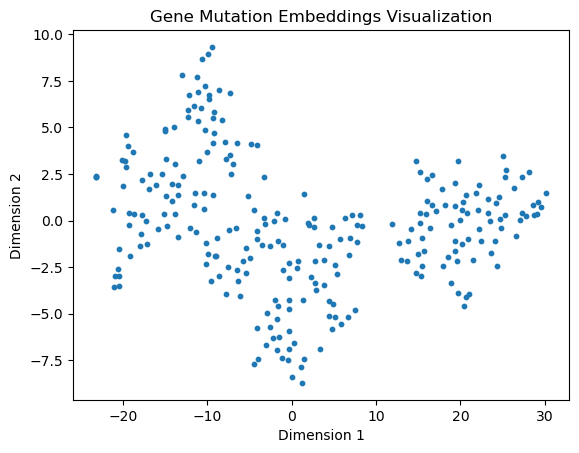

In [21]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Reduce dimensions with t-SNE
reduced_embeddings = TSNE(n_components=2, random_state=42).fit_transform(gene_embeddings.cpu().numpy())

# Plot the embeddings
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], s=10)
plt.title("Gene Mutation Embeddings Visualization")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()

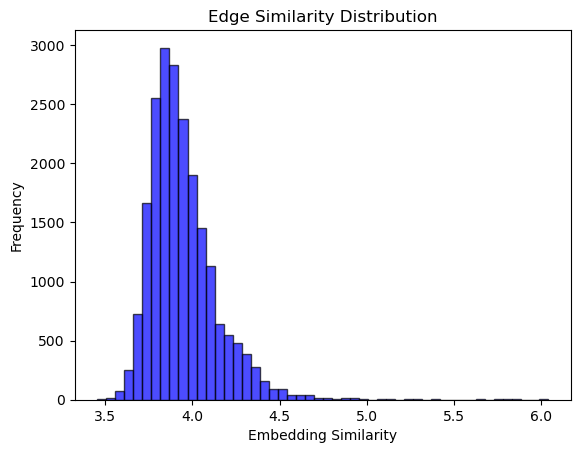

In [22]:
edge_similarity = (gene_embeddings[graph.edge_index[0]] * gene_embeddings[graph.edge_index[1]]).sum(dim=1)
plt.hist(edge_similarity.cpu().numpy(), bins=50, alpha=0.7, color='blue', edgecolor='black')
plt.title("Edge Similarity Distribution")
plt.xlabel("Embedding Similarity")
plt.ylabel("Frequency")
plt.show()

In [23]:
# save the embeddings to a file
torch.save(gene_embeddings, "../data/msk_2024_gene_embeddings.pt")

In [43]:
import pandas as pd

df = pd.read_csv("../data/msk_2024_mutations_clean.csv")

# Add Gene Nodes
gene_counts = df['Gene'].value_counts(normalize=True)
genes_to_keep = gene_counts[gene_counts >= 0.001].index
df = df[df['Gene'].isin(genes_to_keep)]
print(f'Genes kept: {len(genes_to_keep)}')

# Extract mutation counts from the original DataFrame
mutation_counts = df['Gene'].value_counts().to_dict()
# rank the mutations based on their counts
mutation_counts_sorted = sorted(mutation_counts.items(), key=lambda x: x[1], reverse=True)
print(mutation_counts_sorted[:10])

gene_nodes = []

for i in graph.x:
    # get the index where the one-hot encoding is 1
    idx = torch.where(i == 1)[0]
    gene_nodes.append(mutation_counts_sorted[idx.item()][0])
    
print(gene_nodes[:10])
    
gene_embeddings_np = gene_embeddings.cpu().numpy()
df_embeddings = pd.DataFrame(gene_embeddings_np, index=gene_nodes)
# Optionally, you can set column names to indicate embedding dimensions
df_embeddings.columns = [f"dim_{i}" for i in range(df_embeddings.shape[1])]
df_embeddings

# Save the DataFrame to a CSV file
df_embeddings.to_csv("gene_embeddings.csv")

print("Gene embeddings saved to gene_embeddings.csv")



Genes kept: 262
[('TP53', 13783), ('KRAS', 7173), ('APC', 7136), ('PIK3CA', 4148), ('EGFR', 2534), ('KMT2D', 2351), ('ARID1A', 2181), ('KMT2C', 1944), ('SMAD4', 1915), ('ATM', 1669)]
['PIK3CA', 'RNF43', 'GATA3', 'ALK', 'ESR1', 'TP53', 'POLE', 'NOTCH4', 'INPP4B', 'FLT4']
Gene embeddings saved to gene_embeddings.csv
